Timbre: the character or quality of a musical sound or voice as distinct from its pitch and intensity.
 - what is making the sound? Instruments
 - How is the instrument being player? Plyaing Techniques
 - How are different instruments being combined? Ensambles

# Import Required Python Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale

from scipy.cluster.hierarchy import fcluster, linkage
from scipy.cluster.vq import kmeans, vq

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import seaborn as sns

# Import and Exam Dataset

In [2]:
# Create columns

timbre_atts= ["T"+str(i) for i in range(1, 91)]
colnames = ["Year"] + timbre_atts

print(colnames)

['Year', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T35', 'T36', 'T37', 'T38', 'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T48', 'T49', 'T50', 'T51', 'T52', 'T53', 'T54', 'T55', 'T56', 'T57', 'T58', 'T59', 'T60', 'T61', 'T62', 'T63', 'T64', 'T65', 'T66', 'T67', 'T68', 'T69', 'T70', 'T71', 'T72', 'T73', 'T74', 'T75', 'T76', 'T77', 'T78', 'T79', 'T80', 'T81', 'T82', 'T83', 'T84', 'T85', 'T86', 'T87', 'T88', 'T89', 'T90']


In [3]:
# Load data set and create dataframe

file_name = "YearPredictionMSD.txt"
df_raw = pd.read_csv(file_name, names= colnames)

df_atts = df_raw[timbre_atts]

In [4]:
df_raw.shape

(515345, 91)

In [5]:
df_raw.describe()

,Year,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,...,T51,T52,T53,T54,T55,T56,T57,T58,T59,T60,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70,T71,T72,T73,T74,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10345.833280,-7375.977440,-3896.275220,-1199.004420,-2564.788120,-1904.984320,-974.702480,-7057.712450,-6953.357360,-8400.603300,-1812.889440,-1387.505490,-718.421050,-9831.453860,-2025.778160,-8390.035450,-4754.937170,-437.722030,-4402.376440,

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Year    515345 non-null  int64  
 1   T1      515345 non-null  float64
 2   T2      515345 non-null  float64
 3   T3      515345 non-null  float64
 4   T4      515345 non-null  float64
 5   T5      515345 non-null  float64
 6   T6      515345 non-null  float64
 7   T7      515345 non-null  float64
 8   T8      515345 non-null  float64
 9   T9      515345 non-null  float64
 10  T10     515345 non-null  float64
 11  T11     515345 non-null  float64
 12  T12     515345 non-null  float64
 13  T13     515345 non-null  float64
 14  T14     515345 non-null  float64
 15  T15     515345 non-null  float64
 16  T16     515345 non-null  float64
 17  T17     515345 non-null  float64
 18  T18     515345 non-null  float64
 19  T19     515345 non-null  float64
 20  T20     515345 non-null  float64
 21  T21     51

### Data visualization

In [7]:
# Check number of columns
print(df_raw.shape[1])      

91


In [8]:
# count number of songs for each year

year_cnt = df_raw['Year'].value_counts().to_dict()
# for year, cnt in year_cnt.items():
#     print(f"{year} : {cnt}")

year_max = df_raw['Year'].max()
year_min = df_raw['Year'].min()
year_range = year_max - year_min + 1
print(f"{year_max} - {year_min} = {year_range}")

2011 - 1922 = 90


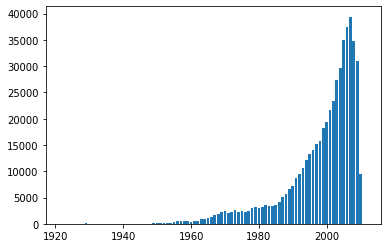

In [9]:
# Plot Bar graph

year_cnt_lst = sorted(year_cnt.items()) 
# print(year_cnt_lst)
x, y = zip(*year_cnt_lst) 

plt.bar(x, y, align='center')
plt.show()

## set original plot for comparison later

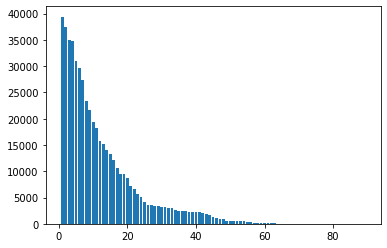

In [10]:
sorted_year_cnt_tuples = sorted(year_cnt.items(), key=lambda item: item[1], reverse = True)
sorted_x, sorted_y = zip(*sorted_year_cnt_tuples) 

plt.bar([*range(1,90)], sorted_y)
plt.show()

## Principal Component Analysis

### Correlation Matrix (or Covariance matrix of Standardized Data)

In [11]:
# all data are numerical, so just take them all 
df = df_atts.iloc[:,:]

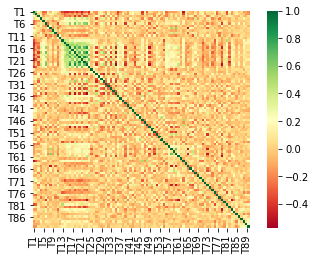

In [12]:
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

In [14]:
""" 
“Covariance” indicates the direction of the linear relationship between variables. 
“Correlation” on the other hand measures both the strength and direction of the linear relationship between two variables
"""

df_corr = df.corr()
df_corr

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,...,T51,T52,T53,T54,T55,T56,T57,T58,T59,T60,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70,T71,T72,T73,T74,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90
T1,1.000000,0.561747,0.245415,0.022270,-0.283635,-0.267820,0.170659,-0.057822,0.218736,0.103704,0.063742,-0.135719,-0.359120,-0.438479,-0.446479,-0.372031,-0.391014,-0.288288,-0.435819,-0.318501,-0.483091,-0.298362,-0.251080,-0.432403,0.106996,-0.147110,-0.170153,0.071698,0.139775,-0.035386,-0.138302,0.102166,-0.094279,-0.049563,-0.049761,-0.380223,-0.179129,0.005297,0.015806,-0.118123,...,-0.068024,-0.105238,0.070950,-0.047993,0.217249,-0.273952,-0.147027,-0.125236,-0.143399,-0.127194,-0.021453,0.112570,-0.518865,0.093357,0.028467,-0.056059,-0.111789,0.048707,-0.099931,0.129509,0.304508,-0.041774,0.078453,0.023752,0.051395,0.260738,-0.237966,-0.003496,0.133392,0.034193,-0.359808,0.190359,-0.137876,0.030790,0.130742,-0.025499,0.048367,-0.145238,-0.105449,-0.183504
T2,0.561747,1.000000,0.018479,0.126845,-0.184864,-0.112388,0.115468,0.108088,0.126086,0.371357,-0.087246,-0.058013,-0.160260,-0.276643,-0.168259,-0.108709,-0.187142,-0.029287,-0.189841,-0.100422,-0.333089,-0.081674,0.003941,-0.281079,-0.089834,-0.045908,-0.188812,0.144542,0.264624,0.053545,-0.155426,0.201881,-0.105850,0.031848,-0.132042,-0.304312,-0.075656,0.231934,-0.067107,-0.160442,...,-0.139569,0.016503,0.141637,-0.112650,0.185909,-0.192463,-0.056762,0.074525,-0.035429,0.029541,-0.002459,0.081143,-0.352473,0.129173,-0.088037,-0.059252,-0.062233,0.108637,-0.088377,0.103441,0.226173,-0.110731,0.017447,0.054829,-0.013319,0.285924,-0.276564,-0.074685,0.065723,0.030322,-0.289733,0.053480,-0.151313,0.022337,0.150309,0.048165,-0.004499,-0.015567,-0.121116,-0.159893
T3,0.245415,0.018479,1.000000,0.152488,-0.131741,0.040808,-0.057642,0.080881,0.043885,-0.089869,0.041447,-0.020443,-0.075219,-0.236458,-0.197375,-0.291798,-0.112668,-0.386215,-0.114689,-0.371624,-0.040652,-0.347095,-0.295373,-0.010870,-0.051478,0.033093,0.209697,0.117118,-0.155834,-0.287104,0.114329,-0.117860,0.243161,-0.112136,0.224575,-0.165085,0.018542,-0.067861,-0.020340,0.067397,...,-0.164228,0.121524,-0.171314,0.070928,-0.113885,-0.217948,-0.038976,0.045579,-0.090247,0.153502,-0.057036,0.079174,-0.143712,0.129376,-0.024642,0.163805,0.118245,-0.203669,0.044610,-0.035847,0.054819,0.172613,-0.228826,-0.091912,0.177845,0.005463,-0.052827,0.065574,-0.109016,-0.015031,0.070644,0.172473,0.109202,-0.007989,-0.033774,-0.093817,0.078392,-0.060559,-0.099712,0.094694
T4,0.022270,0.126845,0.152488,1.000000,0.034988,0.321159,0.282162,0.031649,-0.037905,0.165343,0.309592,-0.103036,-0.025147,0.150262,0.270506,0.357279,0.149118,0.516591,0.155926,0.301542,0.015263,0.300744,0.435414,0.040093,-0.030103,0.096401,-0.358660,-0.019718,0.341134,0.319784,-0.099214,0.119724,-0.152007,0.305984,-0.278722,-0.101551,0.087190,0.191226,-0.060426,-0.204280,...,0.149169,-0.040916,0.072971,-0.173292,-0.078758,0.141827,-0.048548,0.053949,-0.046679,-0.060658,0.146864,-0.030744,-0.037436,0.009713,-0.183840,-0.114650,-0.167536,0.407770,-0.138733,0.079792,0.029508,-0.119772,0.104334,0.133898,-0.203185,-0.095775,-0.004992,-0.266636,0.029030,-0.064654,-0.018894,-0.090732,0.043403,0.058974,-0.067529,0.041973,0.031072,0.248128,0.034055,0.011724
T5,-0.283635,-0.184864,-0.131741,0.034988,1.000000,0.015561,-0.103110,-0.013265,-0.217551,-0.104766,0.016072,0.030181,0.147951,0.217888,0.254846,0.225853,0.197652,0.169753,0.325425,0.242212,0.239394,0.255149,0.182066,0.287732,-0.063531,0.024171,0.110835,-0.005588,-0.016410,-0.023081,0.069952,0.041626,0.003542,0.020706,0.007306,0.083298,0.061458,0.163700,-0.031438,-0.003721,...,-0.066387,0.095197,0.036088,-0.015391,-0.105292,0.153700,0.086507,0.058394,0.118858,0.045447,0.041477,-0.051678,0.168626,-0.077027,0.022072,-0.021948,-0.002062,0.028413,0.049091,0.052245,-0.090166,-0.076811,0.003188,0.091819

In [15]:
w_, v_ = np.linalg.eig(df_corr)

# print(f"Eigenvalues: \n{w_}")
# print(f"Eigenvectors: \n{v_}")

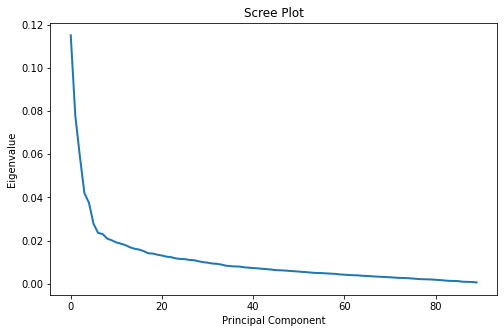

In [16]:
#Determing the number of principal components
"""
To deal with a not-so-ideal scree plot curve, there are a couple ways:
    Kaiser rule: pick PCs with eigenvalues of at least 1.
    Proportion of variance plot: the selected PCs should be able to describe at least 80% of the variance.
""" 

unsorted_PVE_ = w_/w_.sum()
PVE_ = sorted(unsorted_PVE_, reverse = True)
# print("PVE_ : \n", PVE_)
# print("np.cumsum(PVE_)")
np.cumsum(PVE_)

fig = plt.figure(figsize=(8,5))

plt.plot(PVE_, linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

In [17]:
eigenval_sum = w_.sum()
eigenval_1 = w_[0].sum()
eigenvals_2 = w_[:10].sum()
eigenvals_3 = w_[:20].sum()
eigenvals_4 = w_[:30].sum()
eigenvals_5 = w_[:40].sum()
eigenvals_6 = w_[:50].sum()
eigenvals_7 = w_[:60].sum()
eigenvals_8 = w_[:70].sum()
eigenvals_9 = w_[:80].sum()
eigenvals_10 = w_[:91].sum()


print(f"first  1 eigenvalue : {np.round(100*eigenval_1/eigenval_sum, 2)}%")
print(f"first 10 eigenvalues: {np.round(100*eigenvals_2/eigenval_sum, 2)}%")
print(f"first 20 eigenvalues: {np.round(100*eigenvals_3/eigenval_sum, 2)}%")
print(f"first 30 eigenvalues: {np.round(100*eigenvals_4/eigenval_sum, 2)}%")
print(f"first 40 eigenvalues: {np.round(100*eigenvals_5/eigenval_sum, 2)}%")
print(f"first 50 eigenvalues: {np.round(100*eigenvals_6/eigenval_sum, 2)}%")
print(f"first 60 eigenvalues: {np.round(100*eigenvals_7/eigenval_sum, 2)}%")
print(f"first 70 eigenvalues: {np.round(100*eigenvals_8/eigenval_sum, 2)}%")
print(f"first 80 eigenvalues: {np.round(100*eigenvals_9/eigenval_sum, 2)}%")
print(f"all   90 eigenvalues: {np.round(100*eigenvals_10/eigenval_sum, 2)}%")

first  1 eigenvalue : 11.5%
first 10 eigenvalues: 44.71%
first 20 eigenvalues: 60.86%
first 30 eigenvalues: 72.41%
first 40 eigenvalues: 78.16%
first 50 eigenvalues: 83.29%
first 60 eigenvalues: 87.19%
first 70 eigenvalues: 91.56%
first 80 eigenvalues: 95.57%
all   90 eigenvalues: 100.0%


## Choose attributes based on PCA result above

In [18]:
# map df column names to values
pca_i_dict = dict()
for (i, v), tim_i in zip(enumerate(unsorted_PVE_, start=1), timbre_atts):
    pca_i_dict[tim_i] = v 

#sort dictionary based on values
sorted_tuples = sorted(pca_i_dict.items(), key=lambda item: item[1], reverse = True)
sorted_pca_i_dict = {k: v for k, v in sorted_tuples}
sorted_pca_i_keys = [i for i in sorted_pca_i_dict.keys()]
print(f"Orders of components based on PCA:\n {sorted_pca_i_keys}")

Orders of components based on PCA:
 ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T19', 'T18', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T39', 'T40', 'T41', 'T42', 'T44', 'T45', 'T49', 'T50', 'T52', 'T54', 'T57', 'T60', 'T61', 'T62', 'T64', 'T66', 'T67', 'T90', 'T71', 'T87', 'T83', 'T84', 'T79', 'T86', 'T81', 'T77', 'T85', 'T78', 'T89', 'T80', 'T76', 'T75', 'T74', 'T73', 'T82', 'T72', 'T70', 'T69', 'T88', 'T68', 'T65', 'T63', 'T59', 'T58', 'T56', 'T55', 'T53', 'T51', 'T48', 'T47', 'T46', 'T43', 'T37', 'T38', 'T36', 'T35']


In [19]:
# choose numbers of attributes (columns)

cols_range = 20
cols_lst_atts = sorted_pca_i_keys[:cols_range]
cols_lst = ["Year"] + cols_lst_atts
print(cols_lst)

['Year', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T19', 'T18', 'T20']


In [20]:
# Update df with selected cloumns
df_sel_pre = df_raw[cols_lst]

   Year        T1        T2  ...        T19        T18        T20
0  2001  49.94357  21.47114  ...  326.51512  383.70912  238.11327
1  2001  48.73215  18.42930  ...  746.47775  415.64880  366.45320
2  2001  50.95714  31.85602  ...  387.69910  507.39931  287.15347
3  2001  48.24750  -1.89837  ...  387.89697  229.30783  249.06662
4  2001  50.97020  42.20998  ...  334.30734  341.61467  322.99589

[5 rows x 21 columns]


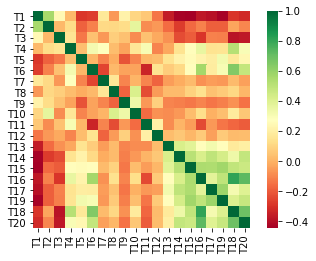

In [21]:
# scatter plot 
# scatter_matrix(df_sel, alpha=1, figsize=(40, 40), diagonal='kde', marker="o")
print(df_sel_pre .head())
sns.heatmap(df_sel_pre [cols_lst_atts].corr(), square=True, cmap='RdYlGn')

In [22]:
df_sel = pd.DataFrame(preprocessing.normalize(df_sel_pre[cols_lst_atts], norm='l2', axis=1, copy=True))

## Hierarchical Clustering (ward method)

In [ ]:
distance_matrix = linkage(df_sel, method='ward', metric='euclidean')

# assign clusters
df_sel['cluster_labels_ward'] = fcluster(distance_matrix, year_range, criterion='maxclust')

## Hierarchical Clustering (complete method)

In [ ]:
distance_matrix = linkage(df_sel[cols_lst_atts], method='complete', metric='euclidean')

# assign clusters
df_sel['cluster_labels_complete'] = fcluster(distance_matrix, year_range, criterion='maxclust')

## Hierarchical Clustering (single method)

In [ ]:
distance_matrix = linkage(df_sel[cols_lst_atts], method='single', metric='euclidean')

# assign clusters
df_sel['cluster_labels_single'] = fcluster(distance_matrix, year_range, criterion='maxclust')

## k-means

In [ ]:
# Generate cluster cneters
cluster_centers, distortion = kmeans(df_sel[cols_lst_atts], year_range)

# assign clusters
df_sel['cluster_labels_kmeans'], distortion_list = vq(df_sel[cols_lst_atts], cluster_centers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# count number of songs for each year

year_cnt2 = df_sel['cluster_labels'].value_counts().to_dict()
for (year, cnt), (labels, cnt2) in zip(year_cnt.items(), year_cnt2.items()):
    print(f"{year} : {cnt}; {labels} : {cnt2}")

year_range2 = df_sel['cluster_labels_kmeans'].max() - df_sel['cluster_labels_kmeans'].min() + 1
print(year_range2)

2007 : 1513; 37 : 7597
2008 : 1371; 38 : 3799
2006 : 1363; 35 : 1660
2005 : 1334; 29 : 1632
2004 : 1276; 31 : 1235
2002 : 928; 34 : 347
2009 : 876; 52 : 334
2003 : 841; 33 : 313
2001 : 840; 22 : 278
2000 : 786; 24 : 209
1999 : 713; 27 : 181
1998 : 711; 26 : 165
1997 : 563; 30 : 162
1995 : 537; 28 : 149
1996 : 488; 25 : 134
1993 : 447; 32 : 122
1994 : 406; 49 : 117
1992 : 355; 50 : 106
1990 : 293; 41 : 98
2010 : 285; 12 : 76
1988 : 281; 19 : 68
1991 : 269; 7 : 44
1989 : 261; 45 : 43
1987 : 197; 46 : 32
1976 : 146; 42 : 29
1986 : 144; 23 : 26
1977 : 140; 40 : 23
1979 : 134; 43 : 19
1972 : 122; 58 : 18
1985 : 122; 14 : 18
1982 : 121; 15 : 18
1974 : 120; 80 : 13
1975 : 119; 51 : 13
1980 : 115; 68 : 12
1973 : 100; 20 : 12
1981 : 99; 74 : 11
1970 : 97; 10 : 11
1983 : 87; 47 : 9
1984 : 86; 39 : 9
1978 : 75; 57 : 8
1971 : 73; 82 : 7
1969 : 71; 59 : 7
1966 : 56; 67 : 6
1967 : 46; 44 : 6
1968 : 41; 76 : 6
1964 : 36; 13 : 6
1965 : 33; 64 : 6
1957 : 28; 81 : 5
1963 : 24; 79 : 5
1956 : 24; 78 : 5
1

In [ ]:
# Plot Bar graph

year_cnt_lst2 = sorted(year_cnt2.items()) 
x2, y2 = zip(*year_cnt_lst2) 

plt.plot(y2)
plt.show()

NameError: ignored

Elbow Method

In [ ]:
distortions = []

clusters_num_lst = range(20, 100, 10)

for i in clusters_num_lst:
  cluster_centers, distortion = kmeans(df_sel[cols_lst_atts], i)
  distortions.append(distortion)

elbow_plot = pd.DataFrame({'clusters': clusters_num_lst, 
                            'distortions': distortions})
  


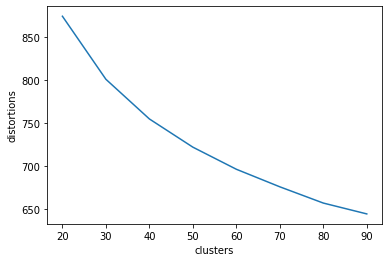

In [ ]:
# create plots
sns.lineplot(x='clusters', y='distortions', data=elbow_plot)
plt.xticks(clusters_num_lst)
plt.show()

# Supervised Learning

In [39]:
X_temp = df_sel_pre.iloc[:,1:].to_numpy()  # selected columns of attributes
X = preprocessing.normalize(X_temp, norm='l2', axis=1)
Y_temp = df_sel_pre.iloc[:,0].to_numpy()
Y = np_utils.to_categorical(minmax_scale(Y_temp, feature_range=(0,year_range-1)))

# Keras Model 1

In [80]:
early_stop = EarlyStopping(monitor='val_loss', mode='min')

In [48]:
model1 = Sequential()

# input layer
model1.add(Dense(90,  input_shape=(cols_range,)))
model1.add(Dropout(0.2))
# 2nd layer
model1.add(Dense(180, activation='relu'))
model1.add(Dropout(0.2))
# output layer
model1.add(Dense(90, activation='sigmoid'))

#compile the model
# model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(f"Loss Function: {model1.loss}")

Loss Function: binary_crossentropy


In [58]:
# fit the model
model1_train = model1.fit(X, Y, validation_split=0.2, epochs=30, verbose=False)

In [60]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 90)                1890      
_________________________________________________________________
dropout_10 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 180)               16380     
_________________________________________________________________
dropout_11 (Dropout)         (None, 180)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 90)                16290     
Total params: 34,560
Trainable params: 34,560
Non-trainable params: 0
_________________________________________________________________


In [71]:
model1.metrics_names

['loss', 'accuracy']

In [82]:
model1.save("model1_file.h5")

# model1_load = load_model("model1_file.h5")
# predictions1 = load_model1.predict(data_to_predict_with)
# probability_true = predictions1[:,1]

# Keras Model 2

In [46]:
model2 = Sequential()

# input layer
model2.add(Dense(90, activation='relu', input_shape=(cols_range,)))
model2.add(Dropout(0.25))
# 2nd layer
model2.add(Dense(180, activation='relu'))
model2.add(Dropout(0.25))
# 3rd layer
model2.add(Dense(180, activation='relu'))
model2.add(Dropout(0.25))
# output layer
model2.add(Dense(90, activation='sigmoid'))

#compile the model
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

print(f"Loss Function: {model2.loss}")

Loss Function: mean_squared_error


In [81]:
# fit the model
model2_train = model2.fit(X, Y, validation_split=0.2, epochs=30, verbose=False)

In [59]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 90)                1890      
_________________________________________________________________
dropout_7 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 180)               16380     
_________________________________________________________________
dropout_8 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 180)               32580     
_________________________________________________________________
dropout_9 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 90)               

In [79]:
model2.metrics_names

['loss', 'accuracy']

In [83]:
model2.save("model2_file.h5")

# model2_load = load_model("model2_file.h5")
# predictions2 = load_model2.predict(data_to_predict_with)
# probability_true = predictions2[:,1]

# Model Comparison Plot

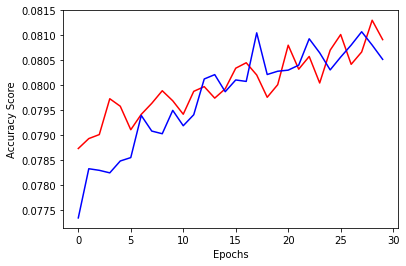

In [87]:
plt.plot(model1_train.history['accuracy'], 'r',
         model2_train.history['accuracy'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.show()

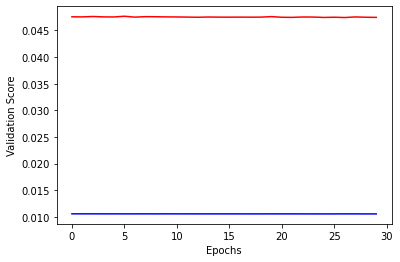

In [86]:
plt.plot(model1_train.history['val_loss'], 'r',
         model2_train.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation Score')
plt.show()